In [13]:
# Install required libraries
!pip install opencv-python matplotlib numpy

In [14]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

In [15]:
# Upload the image manually
uploaded = files.upload()
image_path = 'cars image.png'

# Read image in color
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or invalid path")

# Convert BGR to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert BGR to Grayscale for processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Resize for faster processing
gray = cv2.resize(gray, (100, 100))
image_rgb = cv2.resize(image_rgb, (100, 100))

# Add Gaussian noise
mean = 0
sigma = 25
gaussian_noise = np.random.normal(mean, sigma, gray.shape).astype(np.float32)
noisy_gray = gray + gaussian_noise
noisy_gray = np.clip(noisy_gray, 0, 255).astype(np.uint8)

# Custom Otsu's Threshold Function
def otsu_threshold(image):
    hist = np.histogram(image, bins=256, range=(0, 256))[0]
    total_pixels = image.size
    hist_norm = hist / total_pixels

    max_variance = 0
    threshold = 0
    for t in range(256):
        w_b = np.sum(hist_norm[:t])
        w_f = np.sum(hist_norm[t:])
        if w_b == 0 or w_f == 0:
            continue
        m_b = np.sum(np.arange(t) * hist_norm[:t]) / w_b
        m_f = np.sum(np.arange(t, 256) * hist_norm[t:]) / w_f
        variance = w_b * w_f * (m_b - m_f) ** 2
        if variance > max_variance:
            max_variance = variance
            threshold = t
    return threshold

Saving cars image.png to cars image (3).png


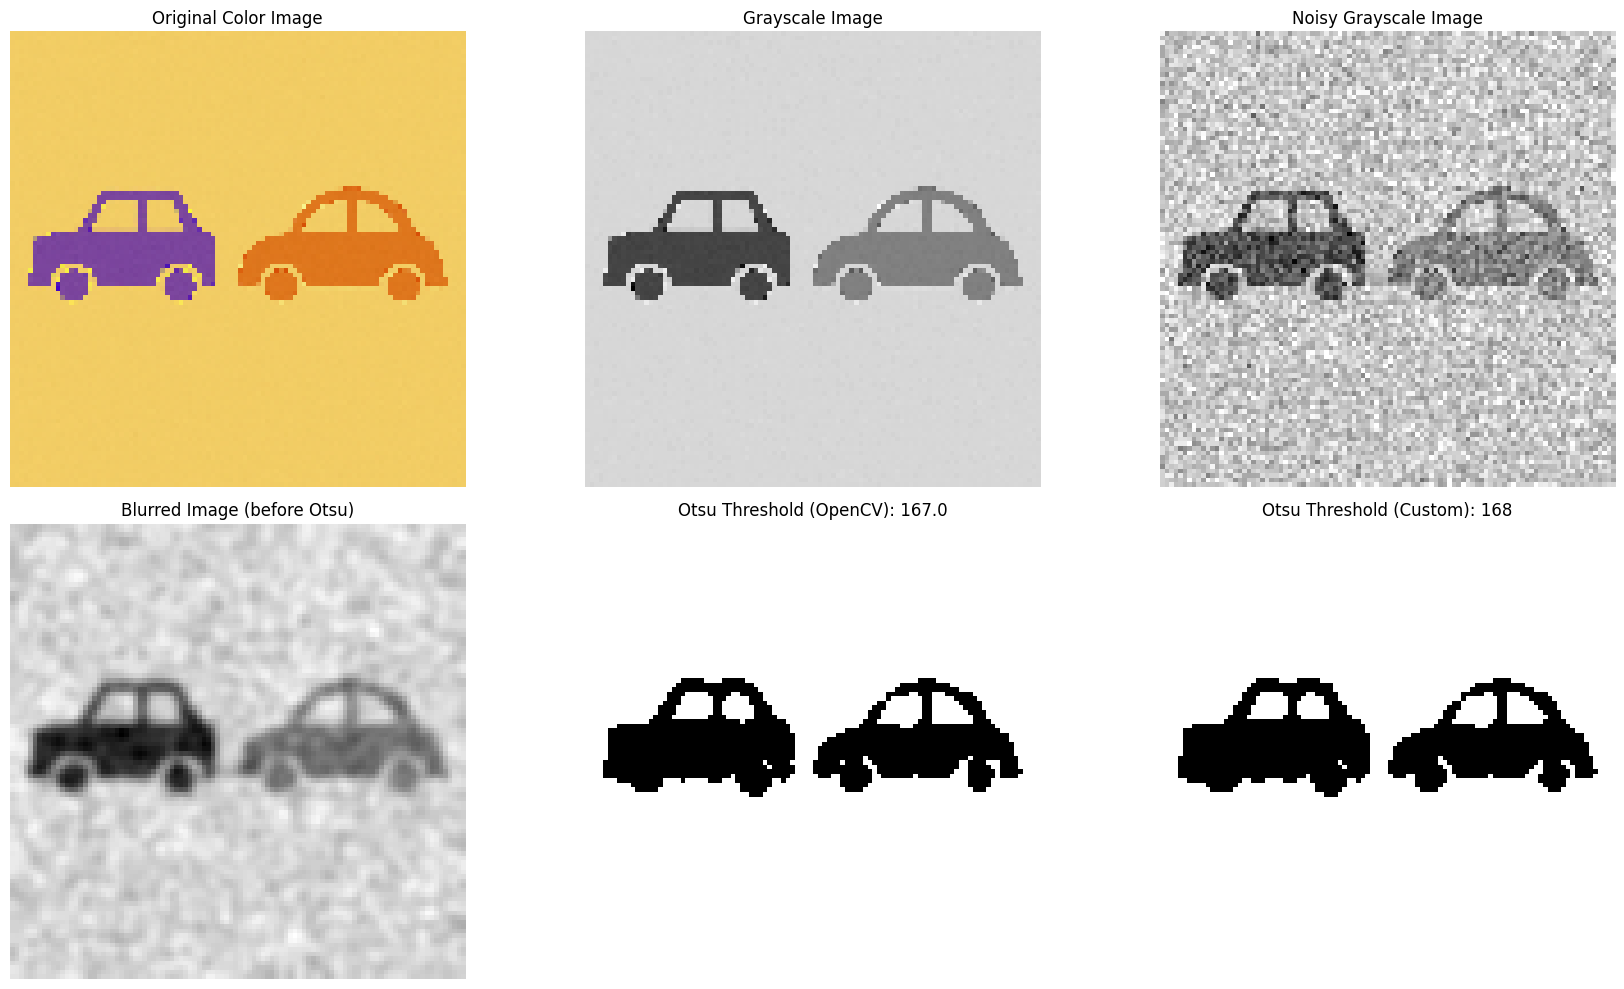

In [16]:
# Apply Gaussian Blur before Otsu
blurred = cv2.GaussianBlur(noisy_gray, (5, 5), 0)

# Apply Otsu's threshold using OpenCV
ret_cv, otsu_cv = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply custom Otsu threshold
custom_thresh = otsu_threshold(blurred)
otsu_custom = (blurred > custom_thresh).astype(np.uint8) * 255

# Display results
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0, 0].imshow(image_rgb)
axs[0, 0].set_title("Original Color Image")
axs[0, 1].imshow(gray, cmap='gray')
axs[0, 1].set_title("Grayscale Image")
axs[0, 2].imshow(noisy_gray, cmap='gray')
axs[0, 2].set_title("Noisy Grayscale Image")

axs[1, 0].imshow(blurred, cmap='gray')
axs[1, 0].set_title("Blurred Image (before Otsu)")
axs[1, 1].imshow(otsu_cv, cmap='gray')
axs[1, 1].set_title(f"Otsu Threshold (OpenCV): {ret_cv}")
axs[1, 2].imshow(otsu_custom, cmap='gray')
axs[1, 2].set_title(f"Otsu Threshold (Custom): {custom_thresh}")

# Hide axes
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


In [17]:
!pip install opencv-python matplotlib numpy


import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from google.colab import files

In [18]:
# Upload image manually
uploaded = files.upload()

# === Parameters ===
image_filename = 'cars image.png'
resize_dim = (100, 100)  # Resize for faster processing
seeds = [(30, 30), (70, 70)]  # Example seeds; adjust based on image
threshold = 20               # Pixel intensity similarity threshold
use_8_connected = True

# === Load and Prepare Image ===
image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Image '{image_filename}' could not be loaded. Please check the filename.")

image = cv2.resize(image, resize_dim)

Saving cars image.png to cars image (4).png


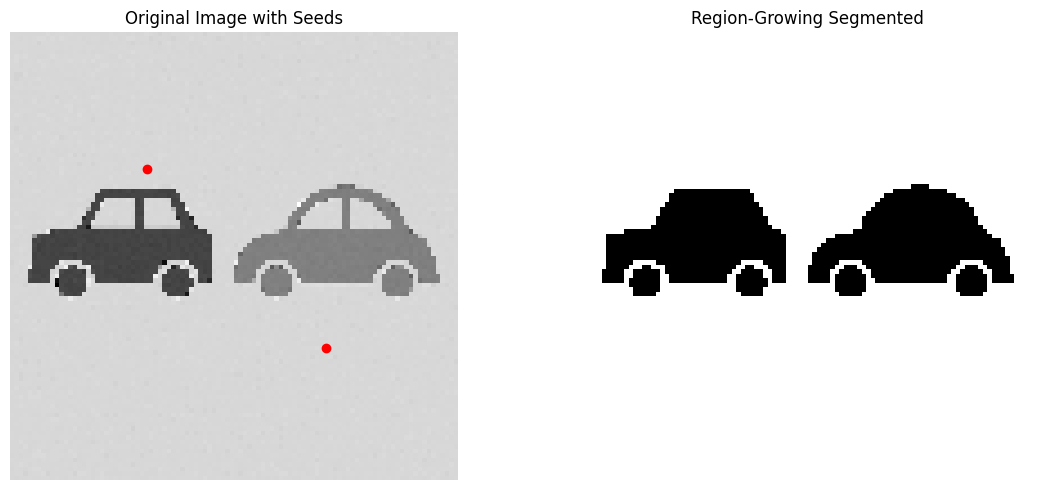

In [19]:
# === Region Growing Function (Hybrid of Stack + Queue) ===
def region_growing(image, seeds, threshold=15, use_8_conn=True):
    height, width = image.shape
    segmented = np.zeros((height, width), np.uint8)
    visited = np.zeros((height, width), np.bool_)
    queue = deque(seeds)

    # Choose neighborhood type
    if use_8_conn:
        neighbors = [(-1, -1), (-1, 0), (-1, 1),
                     (0, -1),          (0, 1),
                     (1, -1),  (1, 0), (1, 1)]
    else:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Initialize region with seed points
    for sx, sy in seeds:
        segmented[sy, sx] = 255
        visited[sy, sx] = True

    # Start region growing
    while queue:
        x, y = queue.popleft()
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                if abs(int(image[ny, nx]) - int(image[y, x])) < threshold:
                    segmented[ny, nx] = 255
                    visited[ny, nx] = True
                    queue.append((nx, ny))
    return segmented

# === Run Region Growing ===
segmented_image = region_growing(image, seeds, threshold=threshold, use_8_conn=use_8_connected)

# === Visualization ===
plt.figure(figsize=(12, 5))

# Original image with seed points
plt.subplot(1, 2, 1)
plt.title("Original Image with Seeds")
plt.imshow(image, cmap='gray')
for x, y in seeds:
    plt.plot(x, y, 'ro')
plt.axis('off')

# Segmented result
plt.subplot(1, 2, 2)
plt.title("Region-Growing Segmented")
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

# Save output
plt.savefig("region_growing_result.png", bbox_inches='tight')
plt.tight_layout()
plt.show()
